In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from shapely.geometry import Point, LineString
from scipy import signal

Let's import the raw data over from Neuralynx (via Matlab as there is currently no good Neuralynx to Python loading functions). A good (but hard!) next step would be to impletment these loading features. A place to start would be the Neo repository <https://github.com/NeuralEnsemble/python-neo>.

In [2]:
def import_csc(matfile):
    load_csc = sio.loadmat(matfile)
    csc = dict(time=[])
    csc['data'] = load_csc['csc_data'][0]
    for val in range(len(load_csc['csc_tvec'])):
        csc['time'].append(load_csc['csc_tvec'][val][0])
    csc['type'] = load_csc['csc_type'][0]
    csc['label'] = load_csc['csc_label'][0][0][0]
    return csc


def import_position(matfile):
    load_pos = sio.loadmat(matfile)
    pos = dict()
    pos['x'] = load_pos['pos_datax'][0]
    pos['y'] = load_pos['pos_datay'][0]
    pos['time'] = load_pos['pos_tvec'][0]
    pos['type'] = load_pos['pos_type'][0]
    pos['label'] = load_pos['pos_label'][0][0][0]
    return pos


def import_videotrack(matfile):
    load_vt = sio.loadmat(matfile)
    vt = dict()
    vt['time'] = load_vt['pos_tsd'][0][0][0][0]
    vt['x'] = load_vt['pos_tsd'][0][0][1][0]
    vt['y'] = load_vt['pos_tsd'][0][0][1][1]

    nan_idx = np.isnan(vt['x']) | np.isnan(vt['y'])
    vt['time'] = vt['time'][~nan_idx]
    vt['x'] = vt['x'][~nan_idx]
    vt['y'] = vt['y'][~nan_idx]
    return vt


def import_events(matfile):
    load_events = sio.loadmat(matfile)
    events = dict()
    events['led1'] = load_events['evt_led1id'][0]
    events['led2'] = load_events['evt_led2id'][0]
    events['ledoff'] = load_events['evt_ledoff'][0]
    events['pb1'] = load_events['evt_pb1id'][0]
    events['pb2'] = load_events['evt_pb2id'][0]
    events['pboff'] = load_events['evt_pboff'][0]
    events['feeder1'] = load_events['evt_feeder1id'][0]
    events['feeder2'] = load_events['evt_feeder2id'][0]
    events['feederoff'] = load_events['evt_feederoff'][0]
    events['type'] = load_events['evt_type'][0]
    events['label'] = load_events['evt_label'][0][0][0]
    return events


def import_spikes(matfile):
    load_spikes = sio.loadmat(matfile)
    spikes = dict()
    spikes['time'] = load_spikes['spikes_times'][0]
    spikes['type'] = load_spikes['spikes_type'][0]
    spikes['label'] = load_spikes['spikes_label'][0][0][0]
    return spikes

The experiment specific information should ideally be stored elsewhere and imported here. But for now, this works!

In [3]:
# Experimental session-specific task times
task_times = dict()
task_times['prerecord'] = [721.9412, 1027.1]
task_times['phase1'] = [1075.8, 1569.6]
task_times['pauseA'] = [1593.9, 2219.0]
task_times['phase2'] = [2243.4, 3512.4]
task_times['pauseB'] = [3556.1, 5441.3]
task_times['phase3'] = [5469.7, 8794.6]
task_times['postrecord'] = [8812.7, 9143.4]

t_start = task_times['phase2'][0]
t_stop = task_times['phase2'][1]

# Session-specific path trajectory points
path_pts = dict()
path_pts['feeder1'] = (468, 471)
path_pts['point1'] = (466, 397)
path_pts['turn1'] = (465, 380)
path_pts['point2'] = (445, 380)
path_pts['point3'] = (298, 398)
path_pts['point4'] = (173, 367)
path_pts['turn2'] = (148, 359)
path_pts['point5'] = (138, 319)
path_pts['point6'] = (140, 103)
path_pts['turn3'] = (155, 69)
path_pts['point7'] = (203, 58)
path_pts['feeder2'] = (661, 54)
path_pts['shortcut1'] = (467, 378)
path_pts['point8'] = (466, 195)
path_pts['point9'] = (496, 166)
path_pts['point10'] = (645, 164)
path_pts['point11'] = (669, 162)
path_pts['point12'] = (672, 146)
path_pts['shortcut2'] = (661, 55)
path_pts['novel1'] = (146, 359)
path_pts['novel2'] = (49, 351)

Loading the data takes some time, it's better to do all at once then not again!

In [4]:
# Load the data
csc = import_csc('emi_inputs_csc.mat')
pos = import_videotrack('emi_inputs_vt.mat')
events = import_events('emi_inputs_event.mat')
spikes = import_spikes('emi_inputs_spike.mat')

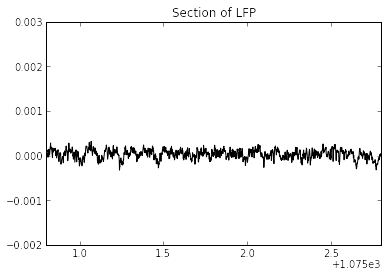

In [5]:
# Plotting lfp
plt.plot(csc['time'], csc['data'], 'k')
plt.xlim(1075.8, 1077.8)
plt.title('Section of LFP')
plt.show()

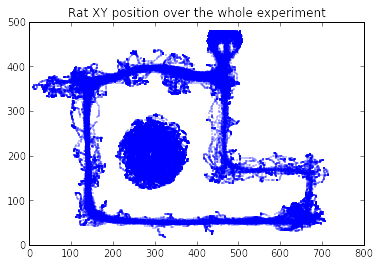

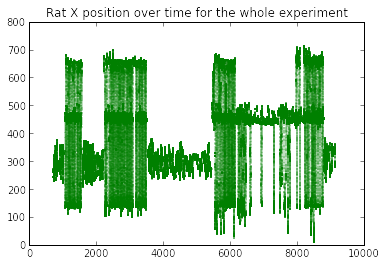

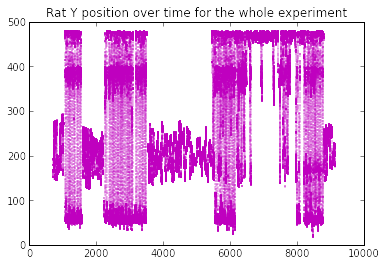

In [6]:
# Plotting position x-y and x-by-time
plt.plot(pos['x'], pos['y'], 'b.', ms=1)
plt.title('Rat XY position over the whole experiment')
plt.show()
plt.plot(pos['time'], pos['x'], 'g.', ms=1)
plt.title('Rat X position over time for the whole experiment')
plt.show()
plt.plot(pos['time'], pos['y'], 'm.', ms=1)
plt.title('Rat Y position over time for the whole experiment')
plt.show()

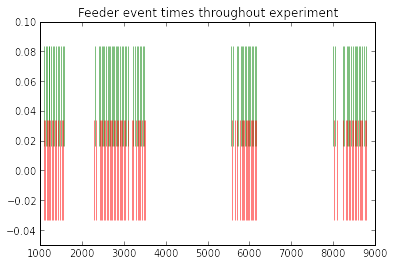

In [7]:
# Plotting feeder event times
plt.plot(events['feeder1'], np.zeros(len(events['feeder1']))+0.05, '|', color='g', ms=100)
plt.plot(events['feeder2'], np.zeros(len(events['feeder2'])), '|', color='r', ms=100)
plt.ylim(-0.05, 0.1)
plt.title('Feeder event times throughout experiment')
plt.show()

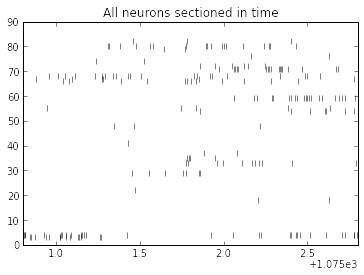

In [8]:
# Plotting spike times
for neuron in range(len(spikes['time'])):
    plt.plot(spikes['time'][neuron], np.ones(len(spikes['time'][neuron]))+neuron+1, '|', color='k')
plt.xlim(1075.8, 1077.8)
plt.title('All neurons sectioned in time')
plt.show()

# Analyses using the data

Now that we have the data in a format that we can work with an visualize, let's see how we can manipulate it to better understand the kinds of things that we're interested in with this type of data!

In [9]:
# Some useful functions
def find_nearest_idx(array, val):
    return (np.abs(array-val)).argmin()


def time_slice(spikes, t_start, t_stop):
    if t_start is None:
        t_start = -np.inf
    if t_stop is None:
        t_stop = np.inf
    indices = (spikes >= t_start) & (spikes <= t_stop)
    sliced_spikes = spikes[indices]
    return sliced_spikes


def linear_trajectory(pos, ideal_path, trial_start, trial_stop):
    t_start_idx = find_nearest_idx(np.array(pos['time']), trial_start)
    t_end_idx = find_nearest_idx(np.array(pos['time']), trial_stop)

    pos_trial = dict()
    pos_trial['x'] = pos['x'][t_start_idx:t_end_idx]
    pos_trial['y'] = pos['y'][t_start_idx:t_end_idx]
    pos_trial['time'] = pos['time'][t_start_idx:t_end_idx]
    
    z = dict(position=[])
    z['time'] = pos_trial['time']
    for point in range(len(pos_trial['x'])):
        position = Point(pos_trial['x'][point], pos_trial['y'][point])
        # linearized_point = ideal_path.interpolate(ideal_path.project(position))
        # linear_pos['x'].append(linearized_point.xy[0])
        # linear_pos['y'].append(linearized_point.xy[1])
        z['position'].append(ideal_path.project(position))
    return z
    
    
def raster_plot(spikes, colour='k'):
    for neuron in range(len(spikes)):
        plt.plot(spikes[neuron], np.ones(len(spikes[neuron]))+neuron+1, 
                 '|', color=colour)

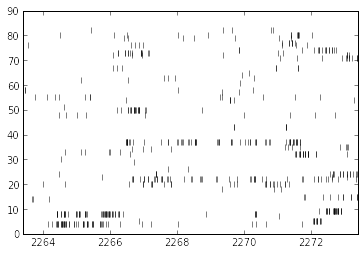

In [10]:
# Slicing spikes
sliced_spikes = dict(time=[])
for neuron in range(len(spikes['time'])):
    sliced_spikes['time'].append(time_slice(spikes['time'][neuron], t_start, t_stop))
assert len(sliced_spikes['time']) == len(spikes['time'])
raster_plot(sliced_spikes['time'])
plt.xlim(t_start+20, t_start+30)
plt.show()

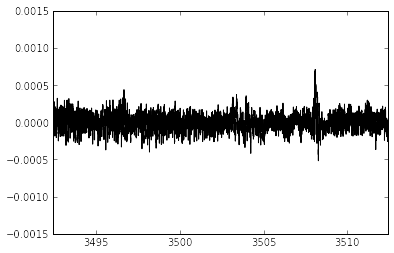

In [11]:
# Slicing LFPs
t_start_idx = find_nearest_idx(np.array(csc['time']), t_start)
t_end_idx = find_nearest_idx(np.array(csc['time']), t_stop)

sliced_csc = dict()
sliced_csc['data'] = csc['data'][t_start_idx:t_end_idx] # Make this into a function to prevent mistakes
sliced_csc['time'] = csc['time'][t_start_idx:t_end_idx]

plt.plot(sliced_csc['time'], sliced_csc['data'], 'k')
plt.xlim(t_stop-20, t_stop)
plt.show()

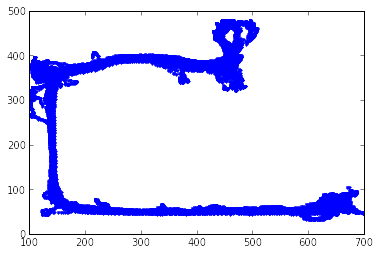

In [12]:
# Slicing position
t_start_idx = find_nearest_idx(np.array(pos['time']), t_start)
t_end_idx = find_nearest_idx(np.array(pos['time']), t_stop)

sliced_pos = dict()
sliced_pos['x'] = pos['x'][t_start_idx:t_end_idx]
sliced_pos['y'] = pos['y'][t_start_idx:t_end_idx]
sliced_pos['time'] = pos['time'][t_start_idx:t_end_idx]

plt.plot(sliced_pos['x'], sliced_pos['y'], 'b.')
plt.show()

Great! So, we can slice any data type in time. Having the position as 2D makes most of the analyses harder, instead let's compress it to 1D by taking an ideal linear trajectory and extracting ('snaping') the actual rat's position to that trajectory.

In [13]:
u_line = LineString([path_pts['feeder1'], path_pts['point1'], path_pts['turn1'], path_pts['point2'],
                        path_pts['point3'], path_pts['point4'], path_pts['turn2'], path_pts['point5'],
                        path_pts['point6'], path_pts['turn3'], path_pts['point7'], path_pts['feeder2']])

shortcut_line = LineString([path_pts['shortcut1'], path_pts['point8'], path_pts['point9'], path_pts['point10'],
                            path_pts['point11'], path_pts['point12'], path_pts['shortcut2']])

novel_line = LineString([path_pts['novel1'], path_pts['novel2']])

In [14]:
linear_u = linear_trajectory(pos, u_line, t_start, t_stop)

In [15]:
phase_spikes = dict(time=[])
for neuron in range(len(spikes['time'])):
        phase_spikes['time'].append(time_slice(spikes['time'][neuron], t_start, t_stop))
assert len(phase_spikes['time']) == len(spikes['time'])

In [28]:
def tuning_curve(position_z, spike_times, num_bins=100, sampling_rate=1/30.0):
    linear_start = np.min(position_z['position'])
    linear_stop = np.max(position_z['position'])
    binned_spikes = np.zeros(num_bins)
    bin_edges = np.linspace(linear_start, linear_stop, num=num_bins)
    bin_centers = np.array((bin_edges[1:] + bin_edges[:-1]) / 2.)
    tc = []
#     gauss_tc = []
    occupancy = np.zeros(len(bin_centers))
    for pos in position_z['position']:
        pos_idx = find_nearest_idx(bin_centers, pos)
        occupancy[pos_idx] += sampling_rate
    occupied_idx = occupancy > 0
    for neuron in range(len(spike_times)):
        spike_z = np.zeros(len(bin_centers))
        for spike_time in spike_times[neuron][0]:
            assigned_bin = find_nearest_idx(np.array(position_z['time']), spike_time)
            which_bin = find_nearest_idx(bin_centers, position_z['position'][assigned_bin])
            spike_z[which_bin] += 1
        firing_rate = np.zeros(len(bin_centers))
        firing_rate[occupied_idx] = spike_z[occupied_idx] / occupancy[occupied_idx]
        tc.append(firing_rate)
#         gauss_filter = signal.get_window(('gaussian', gaussian_shape/2.5), gaussian_shape*12.)
#         gauss_tc.append(np.convolve(firing_rate, gauss_filter, mode='same'))
    return tc

In [73]:
def filter_tc(tuning_curve, filter_type='gaussian', gaussian_std=3.):
    if filter_type == 'gaussian':
        gauss_tc = []
        # Normalized gaussian filter
        gaussian_filter = signal.get_window(('gaussian', gaussian_std), gaussian_std*6.)
        normalized_gaussian = gaussian_filter / np.sum(gaussian_filter)
        for firing_rate in tuning_curve:
            gauss_tc.append(np.convolve(firing_rate, normalized_gaussian, mode='same'))
        return gauss_tc

In [72]:
print 18/3.

6.0


In [31]:
sampling_rate = 1 / 30.0
filtering = 4
min_spikes = 100
max_spikes = len(linear_u['time']) * sampling_rate * filtering
filtered_freq_spikes = dict(time=[])
for neuron in range(len(phase_spikes['time'])):
    if (len(phase_spikes['time'][neuron]) > min_spikes) and (len(phase_spikes['time'][neuron]) <= max_spikes):
        filtered_freq_spikes['time'].append([phase_spikes['time'][neuron]])

In [32]:
tc = tuning_curve(linear_u, filtered_freq_spikes['time'], num_bins=47)

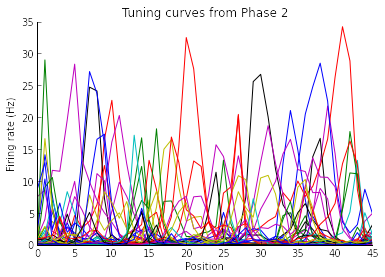

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)
for curve in tc:
    ax.plot(curve)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.ylabel('Firing rate (Hz)')
plt.xlabel('Position')
plt.title('Tuning curves from Phase 2')
plt.show()

In [74]:
filtered_tc = filter_tc(tc)

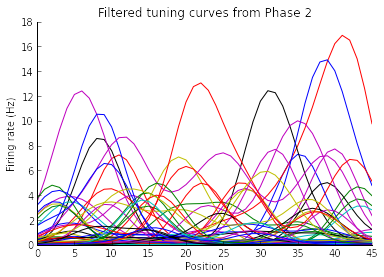

In [75]:
fig = plt.figure()
ax = fig.add_subplot(111)
for curve in filtered_tc:
    ax.plot(curve)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.ylabel('Firing rate (Hz)')
plt.xlabel('Position')
plt.title('Filtered tuning curves from Phase 2')
plt.show()

Okay, that does something! But we can't be sure that it's doing what we want it to do without some sort of test. Let's generate some spikes that follow a specific distribution and then use this same code to determine their tuning curves.

In [ ]:
toy_spike_times = [[np.array([0.21, 0.31])], [np.array([0.1, 0.11])], [np.array([0.38])]]
toy_linear = dict(position=[], time=[])
min_position = np.min(linear_u['position'])
max_position = np.max(linear_u['position'])
position_center = (max_position + min_position) / 2.0
toy_linear['position'] = [min_position, position_center, position_center, max_position]
toy_linear['time'] = [0.11, 0.21, 0.31, 0.41]
toy_tc = tuning_curve(toy_linear, toy_spike_times, num_bins=50)

In [ ]:
for tc in toy_tc:
    plt.plot(tc, lw=2)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Position')
plt.title('Unit test for tuning curves')
plt.show()